<a href="https://colab.research.google.com/github/sandhrabijoy/Pytorch-and-ML-learning/blob/master/pytorch_practice3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np, pandas as pd, pylab as pl
import h5py,torch,re
from tensorflow import image as timage
from torchvision.datasets import CIFAR10 as tcifar10
from torchvision import transforms,utils
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
from torch.utils.data.dataset import Subset
import torch.nn as tnn
import torch.utils.checkpoint as tcp
from collections import OrderedDict as od
from IPython.core.magic import register_line_magic
dev= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class TData(tds):
  def __init__(self,X,y):
    self.X=torch.tensor(X,dtype=torch.float32)
    self.y=torch.tensor(y,dtype=torch.int32)
  def __getitem__(self, index):
    train_img,train_lbl=self.X[index],self.y[index]
    return train_img,train_lbl
  def __len__(self):
    return self.y.shape[0]

In [3]:
def load_h5py(path,img_size):
  f=h5py.File(path,'r')
  keys=list(f.keys());print(keys)
  x=np.array(f[keys[1]],dtype='float32')/255
  x=x.reshape(-1,3,img_size,img_size)
  y=np.array(f[keys[2]],dtype='int32')-1
  N=len(y);n=int(.2*N)
  shuffle_ids=np.arange(N)
  np.random.RandomState(23).shuffle(shuffle_ids)
  x,y=x[shuffle_ids],y[shuffle_ids]
  x_test,x_valid,x_train=x[:n],x[n:2*n],x[2*n:]
  y_test,y_valid,y_train=y[:n],y[n:2*n],y[2*n:]

  df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],[x_train.dtype,x_valid.dtype,x_test.dtype],[y_train.shape,y_valid.shape,y_test.shape],[y_train.dtype,y_valid.dtype,y_test.dtype]],
                  columns=['train','valid','test'],index=['image shape','image type','label shape','label type'])
  display(df)
  return[[x_train,x_valid,x_test],[y_train,y_valid,y_test]]


In [4]:
def display_examples(data_loader,img_size):
  for images,labels in data_loader:
    print('Image dimensions:%s'%str(images.shape))
    print('Label dimensions:%s'%str(labels.shape))
    n=np.random.randint(1,50)
    fig=pl.figure(figsize=(11,4))
    for i in range(n,n+5):
      ax=fig.add_subplot(1,5,i-n+1,xticks=[],yticks=[],title=labels[i].item())
      ax.imshow((images[i]).reshape(img_size,img_size,3))
      break
def show_image(img):
  npimg=img.numpy()/2.+.5;tr=(1,2,0)
  pl.figure(figsize=(10,2))
  pl.imshow(np.transpose(npimg,tr))
  pl.xticks([]);pl.show()

def show_examples(data_loader,classes,num_examples):
  dataiter=iter(data_loader)
  images,labels=next(dataiter)
  show_image(utils.make_grid(images[0:num_examples]))
  print('^'.join(('%9s' % classes[labels[j]] for j in range(num_examples))), end='^')

In [5]:
def model_acc(model,data_loader):
  model.eval()
  correct_preds,num_examples=0,0
  for features,targets in data_loader:
    features=features.to(dev)
    targets=targets.to(dev)
    logits,probs=model(features)
    _,pred_labels=torch.max(probs,1)
    num_examples+=targets.size(0)
    correct_preds+=(pred_labels==targets).sum()
  return correct_preds.float()/num_examples*100

@register_line_magic
def print_acc(n):
  if int(n)==1:
    data_loader=[train_loader,valid_loader,test_loader]
  if int(n)==2:
    data_loader=[train_loader2,valid_loader2,test_loader2]
  print('Train accuracy:%.4f%%'%(model_acc(model,data_loader[0])))
  print('Valid acccuracy:%.4f%%'%(model_acc(model,data_loader[1])))
  print('Test acccuracy:%.4f%%'%(model_acc(model,data_loader[2])))

In [6]:
#data
random_seed=12;batch_size=128
train_ids=torch.arange(0,44000)
valid_ids=torch.arange(44000,50000)
tr0=(.5,.5,.5)
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(tr0,tr0)])
train_valid=tcifar10(root='data',transform=transform,download=True,train=True)
train=Subset(train_valid,train_ids)
valid=Subset(train_valid,valid_ids)
test=tcifar10(root='data',train=False,transform=transform)
train_loader=tdl(dataset=train,shuffle=True,batch_size=batch_size)
valid_loader=tdl(dataset=valid,shuffle=True,batch_size=batch_size)
test_loader=tdl(dataset=test,shuffle=False,batch_size=batch_size)



100%|██████████| 170M/170M [00:01<00:00, 101MB/s]


Extracting data/cifar-10-python.tar.gz to data


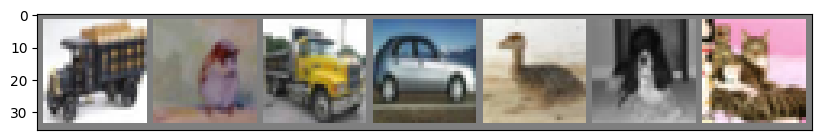

    truck^     bird^    truck^      car^     bird^      dog^      cat^

In [7]:
classes=('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')
show_examples(valid_loader,classes,7)

In [10]:
fpath='/content/data/LetterColorImages.h5'

[[x_train,x_valid,x_test], [y_train,y_valid,y_test]]=load_h5py(fpath,32)

['backgrounds', 'images', 'labels']


,train,valid,test
image shape,"(990, 3, 32, 32)","(330, 3, 32, 32)","(330, 3, 32, 32)"
image type,float32,float32,float32
label shape,"(990,)","(330,)","(330,)"
label type,int32,int32,int32


Image dimensions:torch.Size([128, 3, 32, 32])
Label dimensions:torch.Size([128])
Image dimensions:torch.Size([128, 3, 32, 32])
Label dimensions:torch.Size([128])
Image dimensions:torch.Size([74, 3, 32, 32])
Label dimensions:torch.Size([74])


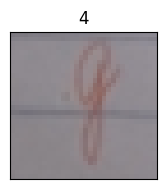

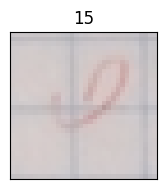

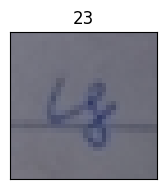

In [11]:
random_seed=23;batch_size2=128
train2=TData(x_train,y_train)
valid2=TData(x_valid,y_valid)
test2=TData(x_test,y_test)
train_loader2=tdl(dataset=train2,batch_size=batch_size2,shuffle=True)
valid_loader2=tdl(dataset=valid2,batch_size=batch_size2,shuffle=True)
test_loader2=tdl(dataset=test2,batch_size=batch_size2,shuffle=False)
display_examples(valid_loader2,32)

In [12]:
#densenet
def _bn_function_call(norm,relu,conv):
  def bn_function(*inputs):
    concated_features=torch.cat(inputs,1)
    bottleneck_output=conv(relu(norm(concated_features)))
    return bottleneck_output
  return bn_function

class _DenseLayer(tnn.Sequential):
  def __init__(self,num_input_features,growth_rate,bn_size,drop_rate,memory_efficient=False):
    super(_DenseLayer,self).__init__()
    self.add_module('norm1',tnn.BatchNorm2d(num_input_features)),
    self.add_module('relu1',tnn.ReLU(inplace=True)),
    self.add_module('conv1',tnn.Conv2d(num_input_features,bn_size*growth_rate,kernel_size=1,stride=1,bias=False)),
    self.add_module('norm2',tnn.BatchNorm2d(bn_size*growth_rate)),
    self.add_module('relu2',tnn.ReLU(inplace=True)),
    self.add_module('conv2',tnn.Conv2d(bn_size*growth_rate,growth_rate,kernel_size=3,stride=1,padding=1,bias=False)),
    self.drop_rate=drop_rate
    self.memory_efficient=memory_efficient

  def forward(self,*prev_features):
    bn_function=_bn_function_call(self.norm1,self.relu1,self.conv1)
    if self.memory_efficient and any(prev_feature.requires_grad for prev_feature in prev_features):
      bottleneck_output=tcp.checkpoint(bn_function,*prev_features)
    else:
      bottleneck_output=bn_function(*prev_features)
    new_features=self.conv2(self.relu2(self.norm2(bottleneck_output)))
    if self.drop_rate>0:
      new_features=tnn.functional.dropout(new_features,p=self.drop_rate,training=self.training)
    return new_features


In [13]:
class _DenseBlock(tnn.Module):
  def __init__(self,num_layers,num_input_features,bn_size,growth_rate,drop_rate,memory_efficient=False):
    super(_DenseBlock,self).__init__()
    for i in range(num_layers):
      layer=_DenseLayer(
          num_input_features+i*growth_rate,
          growth_rate=growth_rate,
          bn_size=bn_size,drop_rate=drop_rate,
          memory_efficient=memory_efficient
      )
      self.add_module('denselayer%d'%(i+1),layer)
  def forward(self,init_features):
    features=[init_features]
    for name,layer in self.named_children():
      new_features=layer(*features)
      features.append(new_features)
    return torch.cat(features,1)

class _Transition(tnn.Sequential):
  def __init__(self,num_input_features,num_output_features):
    super(_Transition,self).__init__()
    self.add_module('norm',tnn.BatchNorm2d(num_input_features))
    self.add_module('relu',tnn.ReLU(inplace=True))
    self.add_module('conv',tnn.Conv2d(num_input_features,num_output_features,kernel_size=1,stride=1,bias=False))
    self.add_module('pool',tnn.AvgPool2d(kernel_size=2,stride=2))


In [14]:

class DenseNN(tnn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_featuremaps=64, bn_size=4, drop_rate=0,
                 num_classes=1000, memory_efficient=False,
                 grayscale=False):
        super(DenseNN, self).__init__()

        in_channels = 1 if grayscale else 3

        self.features = tnn.Sequential(od([
            ('conv0', tnn.Conv2d(in_channels=in_channels,
                                  out_channels=num_init_featuremaps,
                                  kernel_size=7, stride=2,
                                  padding=3, bias=False)),
            ('norm0', tnn.BatchNorm2d(num_features=num_init_featuremaps)),
            ('relu0', tnn.ReLU(inplace=True)),
            ('pool0', tnn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        ]))

        num_features = num_init_featuremaps

        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size, drop_rate=drop_rate,
                growth_rate=growth_rate,
                memory_efficient=memory_efficient)

            self.features.add_module(f'denseblock{i+1}', block)
            num_features += num_layers * growth_rate

            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module(f'transition{i+1}', trans)
                num_features //= 2

        self.features.add_module('norm5', tnn.BatchNorm2d(num_features))
        self.classifier = tnn.Linear(num_features, num_classes)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, tnn.Conv2d):
                tnn.init.kaiming_normal_(m.weight)
            elif isinstance(m, tnn.BatchNorm2d):
                tnn.init.constant_(m.weight, 1)
                tnn.init.constant_(m.bias, 0)
            elif isinstance(m, tnn.Linear):
                tnn.init.constant_(m.bias, 0)

    def forward(self, x):
        y = self.features(x)
        y = tnn.functional.relu(y, inplace=True)
        y = tnn.functional.adaptive_avg_pool2d(y, (1, 1))
        y = torch.flatten(y, 1)
        logits = self.classifier(y)
        probs = tnn.functional.softmax(logits, dim=1)
        return logits, probs


In [15]:
#training
random_seed=34;num_classes=10
learning_rate=.001;grayscale=False
model=DenseNN(num_classes=num_classes,grayscale=grayscale)
model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [16]:
@register_line_magic
def train_run(epochs, patience=5):
    epochs = int(epochs)
    best_valid_acc = 0.0
    no_improve_epochs = 0

    for epoch in range(epochs):
        model.train()
        for batch_ids, (features, targets) in enumerate(train_loader):
            features, targets = features.to(dev), targets.to(dev)
            logits, probs = model(features)
            cost = tnn.functional.cross_entropy(logits, targets)

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            if not batch_ids % 100:
                print(f'Epoch:{epoch+1:03d}/{epochs:03d} | Batch:{batch_ids:03d}/{len(train)//batch_size} | Cost:{cost:.4f}')

        # Model evaluation (outside batch loop)
        model.eval()
        with torch.no_grad():
            train_acc = model_acc(model, train_loader)
            valid_acc = model_acc(model, valid_loader)
            print(f'Epoch:{epoch+1:03d}/{epochs:03d} | Train Acc: {train_acc:.2f}% | Valid Acc: {valid_acc:.2f}%')

            # Early stopping check
            if valid_acc > best_valid_acc:
                best_valid_acc = valid_acc
                no_improve_epochs = 0
                torch.save(model.state_dict(), "best_model.pth")  # Save the best model
            else:
                no_improve_epochs += 1
                if no_improve_epochs >= patience:
                    print(f"Early stopping triggered after {patience} epochs without improvement.")
                    break


In [17]:
%train_run 20

Epoch:001/020 | Batch:000/343 | Cost:2.4372
Epoch:001/020 | Batch:100/343 | Cost:1.4897
Epoch:001/020 | Batch:200/343 | Cost:1.3771
Epoch:001/020 | Batch:300/343 | Cost:1.2680
Epoch:001/020 | Train Acc: 54.23% | Valid Acc: 53.35%
Epoch:002/020 | Batch:000/343 | Cost:1.0502
Epoch:002/020 | Batch:100/343 | Cost:0.9752
Epoch:002/020 | Batch:200/343 | Cost:1.0520
Epoch:002/020 | Batch:300/343 | Cost:1.0597
Epoch:002/020 | Train Acc: 70.31% | Valid Acc: 67.03%
Epoch:003/020 | Batch:000/343 | Cost:0.7922
Epoch:003/020 | Batch:100/343 | Cost:0.8154
Epoch:003/020 | Batch:200/343 | Cost:0.8192
Epoch:003/020 | Batch:300/343 | Cost:0.8817
Epoch:003/020 | Train Acc: 76.15% | Valid Acc: 69.52%
Epoch:004/020 | Batch:000/343 | Cost:0.7641
Epoch:004/020 | Batch:100/343 | Cost:0.7704
Epoch:004/020 | Batch:200/343 | Cost:0.6280
Epoch:004/020 | Batch:300/343 | Cost:0.6163
Epoch:004/020 | Train Acc: 81.31% | Valid Acc: 71.60%
Epoch:005/020 | Batch:000/343 | Cost:0.4969
Epoch:005/020 | Batch:100/343 | Cost

In [18]:
%print_acc 1

Train accuracy:97.0909%
Valid acccuracy:76.9000%
Test acccuracy:75.3400%
